# DTSA-5511:  Week 5 - Kaggle Mini Project



## Generative Adversarial Networks 
### Introduction

This project of Week 5 assignment will apply Generative Adversarial Network (GAN) to image datasets. The source of dataset is from [Kaggle Competition]: Monet Painting Dataset(https://www.kaggle.com/competitions/gan-getting-started).
The data setsets contain an image set with 7,038 photographs and and image set with 300 Monet paintings. The goal of the project is to perform style transfer from photographs to images. 





In [ ]:
! pip install tensorflow_addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.1 MB 5.0 MB/s 


In [ ]:

from tensorflow import keras
from tensorflow.keras import layers
import pandas as pd
import numpy as np
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
import warnings
import os
from PIL import Image, ImageDraw
import IPython.display as display
import shutil
import cv2
import tensorflow as tf
import tensorflow_addons as tfa


try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Device:', tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except:
    strategy = tf.distribute.get_strategy()
print('Number of replicas:', strategy.num_replicas_in_sync)

AUTOTUNE = tf.data.experimental.AUTOTUNE
    
print(tf.__version__)
from tensorflow.keras.models import Sequential
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
warnings.filterwarnings('ignore')
%matplotlib inline
pd.set_option('display.max_columns', None)
color = ['#247BA0', '#F6511D', '#7FB800', '#FFB400', '#F25F5C', '#50514F']

import random

AUTOTUNE = tf.data.AUTOTUNE
RANDOM_SEED = 42
    
print("TensorFlow version:", tf.__version__)


Number of replicas: 1
2.9.2
TensorFlow version: 2.9.2


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%%capture
! unzip "/content/drive/MyDrive/gan-getting-started.zip"

### Exploratory Data Analysis (EDA)
Loading data, cleaning, and inspecting data

In [ ]:
! ls 

drive  monet_jpg  monet_tfrec  photo_jpg  photo_tfrec  sample_data


In [ ]:

#Loading the image datasets
MONET = tf.io.gfile.glob('/content/monet_tfrec/*.tfrec')

PHOTO = tf.io.gfile.glob('/content/photo_tfrec/*.tfrec')

MONET_2 = r'/content/monet_jpg'

PHOTO_2 = r'/content/photo_jpg'

In [ ]:
print(len(MONET))

5


In [ ]:
print( str(MONET_2) + ' monet images in the dataset')
print( str(PHOTO_2) + ' photo images in the dataset')
print(str(MONET) + ' monet image TFRecordDataset files')
print(str(PHOTO) + ' photo image TFRecordDataset files')

/content/monet_jpg monet images in the dataset
/content/photo_jpg photo images in the dataset
['/content/monet_tfrec/monet16-60.tfrec', '/content/monet_tfrec/monet08-60.tfrec', '/content/monet_tfrec/monet12-60.tfrec', '/content/monet_tfrec/monet04-60.tfrec', '/content/monet_tfrec/monet00-60.tfrec'] monet image TFRecordDataset files
['/content/photo_tfrec/photo10-352.tfrec', '/content/photo_tfrec/photo19-350.tfrec', '/content/photo_tfrec/photo04-352.tfrec', '/content/photo_tfrec/photo06-352.tfrec', '/content/photo_tfrec/photo17-352.tfrec', '/content/photo_tfrec/photo02-352.tfrec', '/content/photo_tfrec/photo12-352.tfrec', '/content/photo_tfrec/photo14-352.tfrec', '/content/photo_tfrec/photo07-352.tfrec', '/content/photo_tfrec/photo00-352.tfrec', '/content/photo_tfrec/photo08-352.tfrec', '/content/photo_tfrec/photo05-352.tfrec', '/content/photo_tfrec/photo15-352.tfrec', '/content/photo_tfrec/photo11-352.tfrec', '/content/photo_tfrec/photo01-352.tfrec', '/content/photo_tfrec/photo16-352.t

In [ ]:
Scan_images = {
    'image': tf.io.FixedLenFeature([], tf.string),
    'image_name': tf.io.FixedLenFeature([], tf.string),
    'target': tf.io.FixedLenFeature([], tf.string),
}

def Images_sample(Samples):

  example =  tf.io.parse_single_example(Samples, Scan_images)
  Temp = tf.image.decode_jpeg(example['image'], channels = 3)
  Images_temp = (tf.cast(Temp, tf.float32) / 127.5) - 1
  Res = tf.reshape(Images_temp, [256, 256, 3])
  return Res

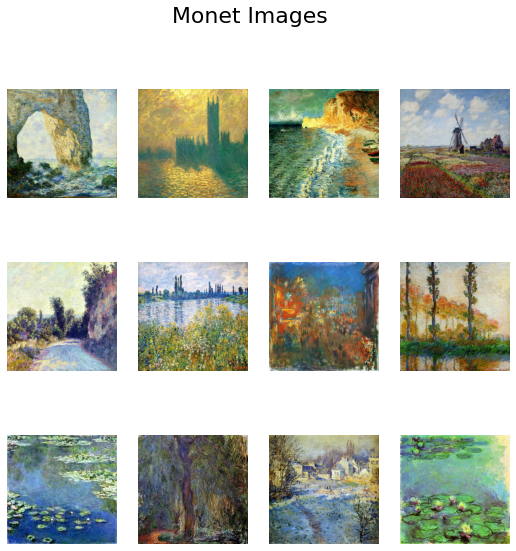

In [ ]:
Monet_samples = tf.data.TFRecordDataset('/content/monet_tfrec/monet00-60.tfrec')
monet_iter = iter(Monet_samples.map(Images_sample).batch(1))
fig, ax = plt.subplots(3, 4, figsize=(9,9))
fig.suptitle('Monet Images', fontsize = 22)
count = 1

for i in range(12):
    image = next(monet_iter)
    plt.subplot(3, 4, count)
    plt.imshow(image[0] * 0.5 + 0.5)
    plt.axis('off')
    count += 1

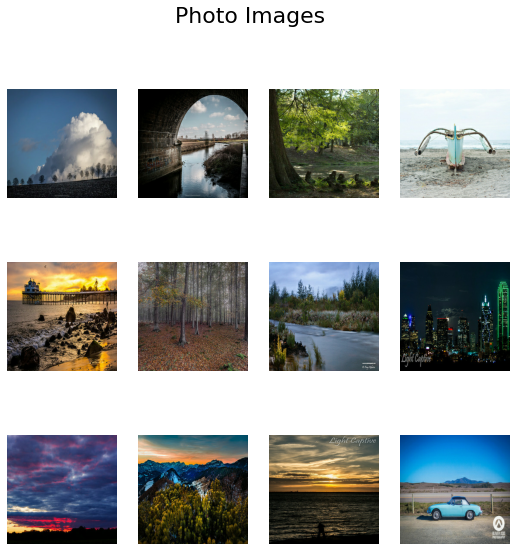

In [ ]:
Photo_samples = tf.data.TFRecordDataset('/content/photo_tfrec/photo00-352.tfrec')
photo_iter = iter(Photo_samples.map(Images_sample).batch(1))
fig, ax = plt.subplots(3, 4, figsize=(9,9))
fig.suptitle('Photo Images', fontsize = 22)
count = 1

for i in range(12):
    image = next(photo_iter)
    plt.subplot(3, 4, count)
    plt.imshow(image[0] * 0.5 + 0.5)
    plt.axis('off')
    count += 1

In [ ]:


Photo_DS = tf.data.TFRecordDataset(PHOTO)
Photo_Temp = Photo_DS.map(Images_sample)
Photo_DS_Parsed = Photo_Temp.batch(1)

Monet_DS = tf.data.TFRecordDataset(MONET)
Monet_Temp = Monet_DS.map(Images_sample)
Monet_DS_Parsed = Monet_Temp.batch(1)

### Model Building and Training



In [ ]:

# Weights of the layers.
kernel_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)
# Gamma of instance normalization.
gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)
# Size of random crops 
input_img_size = (256, 256, 3)

In [ ]:
class PaddingLayers(layers.Layer):


    def __init__(self, padding=(1, 1), **kwargs):
        self.padding = tuple(padding)
        super(PaddingLayers, self).__init__(**kwargs)

    def call(self, input_tensor, mask=None):
        padding_width, padding_height = self.padding
        padding_tensor = [
            [0, 0],
            [padding_height, padding_height],
            [padding_width, padding_width],
            [0, 0],
        ]
        return tf.pad(input_tensor, padding_tensor, mode="REFLECT")


def residualLayers(
    x,
    activation,
    kernel_initializer=kernel_init,
    kernel_size=(3, 3),
    strides=(1, 1),
    padding="valid",
    gamma_initializer=gamma_init,
    use_bias=False,
):
    dim = x.shape[-1]
    input_tensor = x

    x = PaddingLayers()(input_tensor)
    x = layers.Conv2D(
        dim,
        kernel_size,
        strides=strides,
        kernel_initializer=kernel_initializer,
        padding=padding,
        use_bias=use_bias,
    )(x)
    x = tfa.layers.InstanceNormalization(gamma_initializer=gamma_initializer)(x)
    x = activation(x)

    x = PaddingLayers()(x)
    x = layers.Conv2D(
        dim,
        kernel_size,
        strides=strides,
        kernel_initializer=kernel_initializer,
        padding=padding,
        use_bias=use_bias,
    )(x)
    x = tfa.layers.InstanceNormalization(gamma_initializer=gamma_initializer)(x)
    x = layers.add([input_tensor, x])
    return x


def downsample(
    x,
    filters,
    activation,
    kernel_initializer=kernel_init,
    kernel_size=(3, 3),
    strides=(2, 2),
    padding="same",
    gamma_initializer=gamma_init,
    use_bias=False,
):
    x = layers.Conv2D(
        filters,
        kernel_size,
        strides=strides,
        kernel_initializer=kernel_initializer,
        padding=padding,
        use_bias=use_bias,
    )(x)
    x = tfa.layers.InstanceNormalization(gamma_initializer=gamma_initializer)(x)
    if activation:
        x = activation(x)
    return x


def upsample(
    x,
    filters,
    activation,
    kernel_size=(3, 3),
    strides=(2, 2),
    padding="same",
    kernel_initializer=kernel_init,
    gamma_initializer=gamma_init,
    use_bias=False,
):
    x = layers.Conv2DTranspose(
        filters,
        kernel_size,
        strides=strides,
        padding=padding,
        kernel_initializer=kernel_initializer,
        use_bias=use_bias,
    )(x)
    x = tfa.layers.InstanceNormalization(gamma_initializer=gamma_initializer)(x)
    if activation:
        x = activation(x)
    return x

In [ ]:
def Generator_res(
    filters=64,
    Block_downsample=2,
    num_residual_blocks=9,
    num_upsample_blocks=2,
    gamma_initializer=gamma_init,
    name=None,
):
    img_input = layers.Input(shape=input_img_size, name=name + "_img_input")
    x = ReflectionPadding2D(padding=(3, 3))(img_input)
    x = layers.Conv2D(filters, (7, 7), kernel_initializer=kernel_init, use_bias=False)(
        x
    )
    x = tfa.layers.InstanceNormalization(gamma_initializer=gamma_initializer)(x)
    x = layers.Activation("relu")(x)

    # Downsampling
    for _ in range(Block_downsample):
        filters *= 2
        x = downsample(x, filters=filters, activation=layers.Activation("relu"))

    # Residual blocks
    for _ in range(num_residual_blocks):
        x = residualLayers(x, activation=layers.Activation("relu"))

    # Upsampling
    for _ in range(num_upsample_blocks):
        filters //= 2
        x = upsample(x, filters, activation=layers.Activation("relu"))

    # Final block
    x = ReflectionPadding2D(padding=(3, 3))(x)
    x = layers.Conv2D(3, (7, 7), padding="valid")(x)
    x = layers.Activation("tanh")(x)

    model = keras.models.Model(img_input, x, name=name)
    return model

In [ ]:
def Discriminator_img(
    filters=64, kernel_initializer=kernel_init, num_downsampling=3, name=None
):
    img_input = layers.Input(shape=input_img_size, name=name + "_img_input")
    x = layers.Conv2D(
        filters,
        (4, 4),
        strides=(2, 2),
        padding="same",
        kernel_initializer=kernel_initializer,
    )(img_input)
    x = layers.LeakyReLU(0.2)(x)

    num_filters = filters
    for num_downsample_block in range(3):
        num_filters *= 2
        if num_downsample_block < 2:
            x = downsample(
                x,
                filters=num_filters,
                activation=layers.LeakyReLU(0.2),
                kernel_size=(4, 4),
                strides=(2, 2),
            )
        else:
            x = downsample(
                x,
                filters=num_filters,
                activation=layers.LeakyReLU(0.2),
                kernel_size=(4, 4),
                strides=(1, 1),
            )

    x = layers.Conv2D(
        1, (4, 4), strides=(1, 1), padding="same", kernel_initializer=kernel_initializer
    )(x)

    model = keras.models.Model(inputs=img_input, outputs=x, name=name)
    return model


# Get the generators
gen_G = Generator_res(name="generator_G")
gen_F = Generator_res(name="generator_F")

# Get the discriminators
disc_X = Discriminator_img(name="discriminator_X")
disc_Y = Discriminator_img(name="discriminator_Y")

In [ ]:
class CycleGan(keras.Model):
    def __init__(
        self,
        generator_G,
        generator_F,
        discriminator_X,
        discriminator_Y,
        lambda_cycle=10.0,
        lambda_identity=0.5,
    ):
        super(CycleGan, self).__init__()
        self.gen_G = generator_G
        self.gen_F = generator_F
        self.disc_X = discriminator_X
        self.disc_Y = discriminator_Y
        self.lambda_cycle = lambda_cycle
        self.lambda_identity = lambda_identity

    def compile(
        self,
        gen_G_optimizer,
        gen_F_optimizer,
        disc_X_optimizer,
        disc_Y_optimizer,
        gen_loss_fn,
        disc_loss_fn,
    ):
        super(CycleGan, self).compile()
        self.gen_G_optimizer = gen_G_optimizer
        self.gen_F_optimizer = gen_F_optimizer
        self.disc_X_optimizer = disc_X_optimizer
        self.disc_Y_optimizer = disc_Y_optimizer
        self.LossGenerator = gen_loss_fn
        self.LossDiscriminator = disc_loss_fn
        self.cycle_loss_fn = keras.losses.MeanAbsoluteError()
        self.identity_loss_fn = keras.losses.MeanAbsoluteError()

    def train_step(self, batch_data):
      
        real_x, real_y = batch_data

      

        with tf.GradientTape(persistent=True) as tape:

            fake_y = self.gen_G(real_x, training=True)
            fake_x = self.gen_F(real_y, training=True)

            
            cycled_x = self.gen_F(fake_y, training=True)
         
            cycled_y = self.gen_G(fake_x, training=True)

            # Identity mapping
            same_x = self.gen_F(real_x, training=True)
            same_y = self.gen_G(real_y, training=True)

            # Discriminator output
            disc_real_x = self.disc_X(real_x, training=True)
            disc_fake_x = self.disc_X(fake_x, training=True)

            disc_real_y = self.disc_Y(real_y, training=True)
            disc_fake_y = self.disc_Y(fake_y, training=True)

            # Generator adverserial loss
            gen_G_loss = self.LossGenerator(disc_fake_y)
            gen_F_loss = self.LossGenerator(disc_fake_x)

            # Generator cycle loss
            cycle_loss_G = self.cycle_loss_fn(real_y, cycled_y) * self.lambda_cycle
            cycle_loss_F = self.cycle_loss_fn(real_x, cycled_x) * self.lambda_cycle

            # Generator identity loss
            id_loss_G = (
                self.identity_loss_fn(real_y, same_y)
                * self.lambda_cycle
                * self.lambda_identity
            )
            id_loss_F = (
                self.identity_loss_fn(real_x, same_x)
                * self.lambda_cycle
                * self.lambda_identity
            )

            # Total generator loss
            total_loss_G = gen_G_loss + cycle_loss_G + id_loss_G
            total_loss_F = gen_F_loss + cycle_loss_F + id_loss_F

            # Discriminator loss
            disc_X_loss = self.LossDiscriminator(disc_real_x, disc_fake_x)
            disc_Y_loss = self.LossDiscriminator(disc_real_y, disc_fake_y)

      
        grads_G = tape.gradient(total_loss_G, self.gen_G.trainable_variables)
        grads_F = tape.gradient(total_loss_F, self.gen_F.trainable_variables)

 
        disc_X_grads = tape.gradient(disc_X_loss, self.disc_X.trainable_variables)
        disc_Y_grads = tape.gradient(disc_Y_loss, self.disc_Y.trainable_variables)

        # Update the weights  
        self.gen_G_optimizer.apply_gradients(
            zip(grads_G, self.gen_G.trainable_variables)
        )
        self.gen_F_optimizer.apply_gradients(
            zip(grads_F, self.gen_F.trainable_variables)
        )

        # Update the weights 
        self.disc_X_optimizer.apply_gradients(
            zip(disc_X_grads, self.disc_X.trainable_variables)
        )
        self.disc_Y_optimizer.apply_gradients(
            zip(disc_Y_grads, self.disc_Y.trainable_variables)
        )

        return {
            "G_loss": total_loss_G,
            "F_loss": total_loss_F,
            "D_X_loss": disc_X_loss,
            "D_Y_loss": disc_Y_loss,}

In [ ]:
# Loss function for evaluating adversarial loss
LossFunction = keras.losses.MeanSquaredError()

# Define the loss function for the generators
def LossGenerator(fake):
    fake_loss = LossFunction(tf.ones_like(fake), fake)
    return fake_loss


# Define the loss function for the discriminators
def LossDiscriminator(real, fake):
    real_loss = LossFunction(tf.ones_like(real), real)
    fake_loss = LossFunction(tf.zeros_like(fake), fake)
    return (real_loss + fake_loss) * 0.5



cycle_gan_model = CycleGan(
    generator_G=gen_G, generator_F=gen_F, discriminator_X=disc_X, discriminator_Y=disc_Y
)

# Compile the model
cycle_gan_model.compile(
    gen_G_optimizer=keras.optimizers.Adam(learning_rate=2e-4, beta_1=0.5),
    gen_F_optimizer=keras.optimizers.Adam(learning_rate=2e-4, beta_1=0.5),
    disc_X_optimizer=keras.optimizers.Adam(learning_rate=2e-4, beta_1=0.5),
    disc_Y_optimizer=keras.optimizers.Adam(learning_rate=2e-4, beta_1=0.5),
    gen_loss_fn=LossGenerator,
    disc_loss_fn=LossDiscriminator,
)



cycle_gan_model.fit(
    tf.data.Dataset.zip((Photo_DS_Parsed, Monet_DS_Parsed)),
    epochs=10,
)

Epoch 1/10
300/300 [==============================] - 283s 740ms/step - G_loss: 5.0285 - F_loss: 5.6356 - D_X_loss: 0.1283 - D_Y_loss: 0.1474
Epoch 2/10
300/300 [==============================] - 222s 741ms/step - G_loss: 4.5748 - F_loss: 4.9812 - D_X_loss: 0.1920 - D_Y_loss: 0.1882
Epoch 3/10
300/300 [==============================] - 223s 742ms/step - G_loss: 4.4239 - F_loss: 4.8854 - D_X_loss: 0.1511 - D_Y_loss: 0.1675
Epoch 4/10
300/300 [==============================] - 221s 735ms/step - G_loss: 4.1746 - F_loss: 4.6436 - D_X_loss: 0.1458 - D_Y_loss: 0.1655
Epoch 5/10
300/300 [==============================] - 222s 740ms/step - G_loss: 4.1388 - F_loss: 4.4396 - D_X_loss: 0.1735 - D_Y_loss: 0.1476
Epoch 6/10
300/300 [==============================] - 222s 739ms/step - G_loss: 4.0873 - F_loss: 4.4095 - D_X_loss: 0.1468 - D_Y_loss: 0.1367
Epoch 7/10
300/300 [==============================] - 221s 738ms/step - G_loss: 3.9545 - F_loss: 4.2831 - D_X_loss: 0.1568 - D_Y_loss: 0.1659
Epoch 

### Results and Analysis
Due to the request of Kaggle, I submit the assignment as notebook in Kaggle for the result of Kaggle competition. During the hyperparameter tunning, I find the progress was visually different while I trying to speed up the training time. The performance of the model didn't change much during the last few epoches.


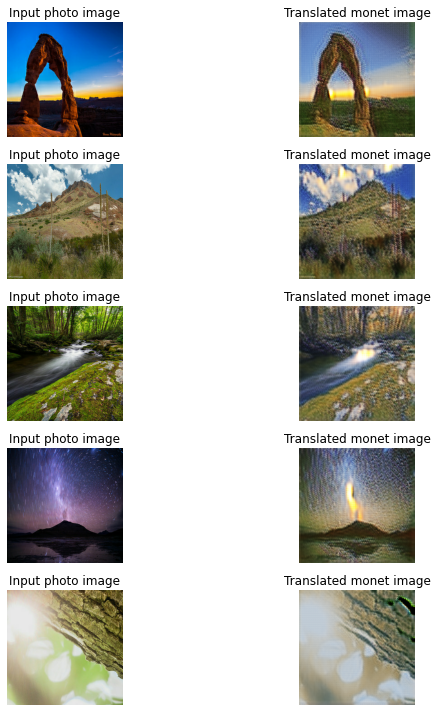

In [ ]:
_, ax = plt.subplots(5, 2, figsize=(10, 10))
for i, img in enumerate(Photo_DS_Parsed.take(5)):
    prediction = cycle_gan_model.gen_G(img, training=False)[0].numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    img = (img[0] * 127.5 + 127.5).numpy().astype(np.uint8)

    ax[i, 0].imshow(img)
    ax[i, 1].imshow(prediction)
    ax[i, 0].set_title("Input photo image")
    ax[i, 1].set_title("Translated monet image")
    ax[i, 0].axis("off")
    ax[i, 1].axis("off")
plt.tight_layout()
plt.show()

In [ ]:
! ls

drive  monet_jpg  monet_tfrec  photo_jpg  photo_tfrec  sample_data


In [ ]:
import PIL
! mkdir images

In [ ]:
i = 1
for img in Photo_DS_Parsed:
    prediction = cycle_gan_model.gen_G(img, training=False)[0].numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    im = PIL.Image.fromarray(prediction)
    im.save("images/" + str(i) + ".jpg")
    i += 1

In [ ]:
import shutil
shutil.make_archive("images", 'zip', "images")

'/content/images.zip'

In [ ]:
count = 1
for img in parsed_photo_image_dataset:
    prediction = cycle_gan_model.gen_G(img, training=False)[0].numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    prediction = keras.preprocessing.image.array_to_img(prediction)
    prediction.save('/content/drive/MyDrive/Colab_Notebooks/submission/{count}.jpg'.format(count=count))
    count += 1

## Conclusion
Overall, the projects shows the time of training GAN model would be very long.  Also, the amount of training data would have big impact on the model results, the full dataset will deliver better result. There is one thing I like to improve the model further would be to implement a "dual head" discriminator which occurs in the top scoring submssions of Kaggles. Moreover, I'm glad I discover this technique which I didn't notice before attending this assignment.  

